In [1]:
from astropy.table import Table
import matplotlib.pyplot as pl
import os
import numpy as np
from astropy.io import fits
from astropy.wcs import wcs
import subprocess

In [2]:
region="off"
filts=["f555w","f814w"]
filts=["f125w","f160w"]


# autoset catalog path based on user
if os.environ['USER'] =='remy':
    workdir="/Users/remy/cv/magellanic/n159/"
    dolbin="/Users/remy/cv/magellanic/dolphot/dolphot2.0/bin/"
    
os.chdir(workdir+region+"/")

c={}
for filt in filts:
    if filt=="f125w" or filt=="f160w":
        kind="flt"  
        camera="wfc3"
        catfile = filt+"/"+region+"_"+filt+"_f160ref"
    else:
        # this is of course particular to this project that we did UVO with ACS and IR with WFC3
        kind="flc"
        camera="acs"
        catfile = filt+"/"+region+"_"+filt+"_f814ref"
    
    print(catfile)
    c[filt]=Table.read(catfile,format="ascii")
    print(len(c[filt]))
    print(c[filt][0:5])

f125w/off_f125w_f160ref
64180
col1 col2  col3   col4  col5  col6  ... col58 col59  col60  col61 col62 col63
---- ---- ------ ------ ---- ------ ... ----- ------ ------ ----- ----- -----
   0    1 671.35 703.74 0.75 6295.8 ...  0.73 2797.4 -0.042 0.002  0.03    14
   0    1 725.76 459.34  0.7 7349.9 ...  0.68 4198.1 -0.012 0.024 0.001     0
   0    1 551.75 919.53 1.03 6261.7 ...  1.28 2287.9 -0.049 0.025 0.021     2
   0    1  866.7 108.93 0.93 5618.6 ...  1.08 2098.9 -0.086 0.021 0.056     2
   0    1  826.8 833.52 0.88 4783.5 ...  0.99 2442.4  -0.06 0.006 0.023     0
f160w/off_f160w_f160ref
60220
col1 col2  col3   col4  col5  col6  ... col71 col72  col73  col74 col75 col76
---- ---- ------ ------ ---- ------ ... ----- ------ ------ ----- ----- -----
   0    1 904.72   0.14 0.05 2258.2 ...  0.05 2258.2 -0.018 0.091   0.0    15
   0    1 671.32 703.75 0.39 7450.4 ...  0.48 3462.2 -0.004 0.012   0.0     4
   0    1 725.73 459.35 0.68 7493.4 ...  0.81 3540.0 -0.037 0.018 0.001     0
   0

In [3]:
# column definitions
mag = 'col16'
dmag= 'col18'
snr = 'col6'
shp = 'col7'
rnd = 'col8'
x   = 'col3'
y   = 'col4'
otype = 'col11'
crd = 'col10'

In [4]:
# get reference file and ra/dec for each filter
for filt in filts:
    # print('grep img_file '+filt+'/dolparms_'+filt+".multi.txt")
    c[filt+"_ref"] = reffile = filt+"/"+subprocess.getoutput('grep img_file '+filt+'/dolparms_'+filt+".multi.txt").split()[-1]+".fits"
    print(reffile)
    c[filt+"_wcs"] = wcs.WCS(fits.getheader(reffile))
    xpix=c[filt][x]
    ypix=c[filt][y]
    ra,de=c[filt+"_wcs"].wcs_pix2world(xpix,ypix,0)
    c[filt+"_ra"]=ra
    c[filt+"_de"]=de
    print(ra[0:10],de[0:10])

f125w/../f160w/f160w_drz_sci_hdu.fits
[85.23506264 85.25250143 85.22391109 85.2737981  85.21488908 85.2310819
 85.28916209 85.27334573 85.27192743 85.24171452] [-69.80338613 -69.80996855 -69.79548525 -69.82124009 -69.80526777
 -69.81742579 -69.81890469 -69.79601512 -69.80785354 -69.80869438]
f160w/../f160w/f160w_drz_sci_hdu.fits
[85.28075425 85.23506357 85.25250236 85.27379285 85.22391109 85.23108139
 85.28915795 85.21488993 85.27334252 85.2719249 ] [-69.82457151 -69.80338505 -69.80996747 -69.82123708 -69.79548525
 -69.8174248  -69.81890239 -69.80526797 -69.79601608 -69.80785293]


In [5]:
match12=np.zeros(len(c[filts[0]]),dtype=int)-1
match21=np.zeros(len(c[filts[1]]),dtype=int)-1
d=0.2 # arcsec

for i in range(len(c[filts[0]])):
    dra=np.absolute(c[filts[0]+"_ra"][i]-c[filts[1]+"_ra"])*np.cos(c[filts[0]+"_de"][i]*np.pi/180)
    dde=np.absolute(c[filts[0]+"_de"][i]-c[filts[1]+"_de"])
    z=np.where( (dra<d)*(dde<d) )[0]
    if len(z)>0:
        d2= dra[z]**2 + dde[z]**2
        zz=z[np.where(d2==d2.min())[0][0]]
        match12[i]=zz
        match21[zz]=i

1.7250646955876223e-05 1.735914601755208e-05
3350 -12.521999999999998 4.992000000000001


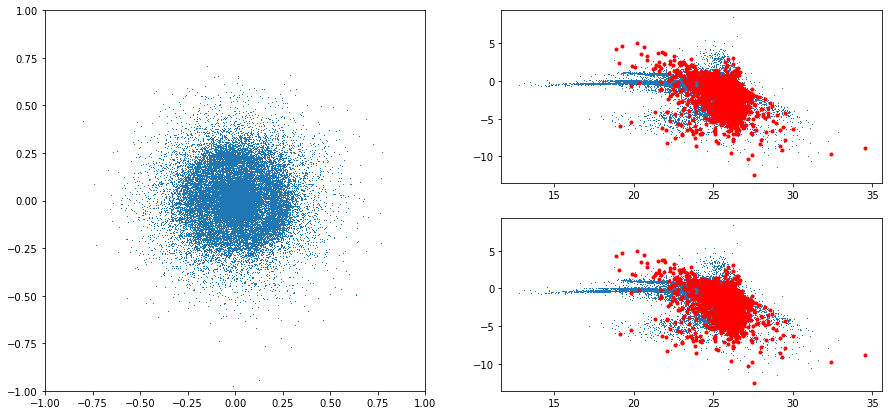

In [7]:
c1=c[filts[0]]
c2=c[filts[1]]

pl.figure(figsize=(15,7))
z=np.where(match12>=0)[0]
z1=z[ np.where((c1[mag][z]<90)*(c2[mag][match12[z]]<90))[0] ]
# print(match12)
pl.subplot(121)
cdec=np.cos(np.pi/180*np.nanmean(c[filts[0]+"_de"][z1]))
pl.plot((c[filts[0]+"_ra"][z1]-c[filts[1]+"_ra"][match12[z1]])*3600*cdec,
        (c[filts[0]+"_de"][z1]-c[filts[1]+"_de"][match12[z1]])*3600,',')
d=1.
pl.ylim(-d,d)
pl.xlim(-d,d)

d=0.3/3600
dra=(c[filts[0]+"_ra"][z1]-c[filts[1]+"_ra"][match12[z1]])*np.cos(c[filts[0]+"_de"][z1]*np.pi/180)
dde=(c[filts[0]+"_de"][z1]-c[filts[1]+"_de"][match12[z1]])
z2=z1[ np.where( (np.absolute(dra)>d) | (np.absolute(dde)>d) )[0] ]
print(np.nanmean(np.absolute(dra)),np.nanmean(np.absolute(dde)))
pl.subplot(222)
pl.plot(c1[mag][z1],c2[mag][match12[z1]]-c1[mag][z1],',')
pl.plot(c1[mag][z2],c2[mag][match12[z2]]-c1[mag][z2],'r.')
print(len(z2),np.min(c2[mag][match12[z2]]-c1[mag][z2]),np.max(c2[mag][match12[z2]]-c1[mag][z2]))
#pl.xlim(17,23)
#pl.ylim(-5,5)

pl.subplot(224)
pl.plot(c1[mag][z1],c2[mag][match12[z1]]-c1[mag][z1],',')
pl.plot(c1[mag][z2],c2[mag][match12[z2]]-c1[mag][z2],'r.')
#pl.xlim(17,23)
#pl.ylim(-0.25,0.25)

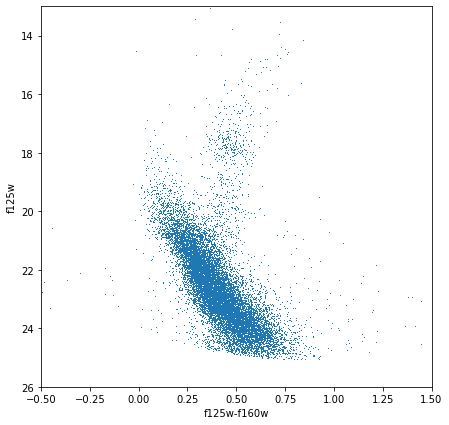

In [10]:
pl.figure(figsize=(7,7))
z=np.where(match12>=0)[0]
c1=c[filts[0]]
c2=c[filts[1]]
z1=z[ np.where((c1[mag][z]<90)*(c2[mag][match12[z]]<90)*
               (c1[dmag][z]<0.1)*(c2[dmag][match12[z]]<0.1)*
               (np.absolute(c1[shp][z])<1)*(np.absolute(c2[shp][match12[z]])<1)*
               (c1[rnd][z]<3)*(c2[rnd][match12[z]]<3)*
               (c1[crd][z]<0.3)*(c2[crd][match12[z]]<0.3)*
               (c1[otype][z]<3)*(c2[otype][match12[z]]<3)
              )[0] ]
pl.plot(c1[mag][z1]-c2[mag][match12[z1]],c1[mag][z1],',')
pl.xlabel(filts[0]+"-"+filts[1])
pl.ylabel(filts[0])
if camera=="acs":
    pl.xlim(-0.5,3.5)
    pl.ylim(28,17)
else:
    pl.xlim(-0.5,1.5)
    pl.ylim(26,13)
      
pl.savefig(region+"_cmd_"+filts[0]+"_"+filts[1]+".png")